In [1]:
from config_submit1 import * #Set the configuration file name
conf = config()

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.11.0
True


In [3]:
import copy
import random
import time
from IPython.display import clear_output
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import timm
from timm.scheduler import CosineLRScheduler
from torch import nn
import torchaudio
import torchaudio.transforms as T
from torchinfo import summary
from torchlibrosa.augmentation import SpecAugmentation 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch.nn.functional as F
import NeSsi.nessi as nessi

In [4]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
root_path = "/data/datasets/TAU-urban-acoustic-scenes-2022-mobile-development/"
setup_path = root_path + "evaluation_setup/"

## checking csv data

In [6]:
train_csv = pd.read_table(setup_path + "fold1_train.csv")
val_csv = pd.read_table(setup_path + "fold1_evaluate.csv")
test_csv = pd.read_table(setup_path + "fold1_test.csv")

In [7]:
display(train_csv.head())
display(val_csv.head())
display(test_csv.head())

,filename,scene_label
0,audio/airport-lisbon-1000-40000-0-a.wav,airport
1,audio/airport-lisbon-1000-40000-1-a.wav,airport
2,audio/airport-lisbon-1000-40000-2-a.wav,airport
3,audio/airport-lisbon-1000-40000-3-a.wav,airport
4,audio/airport-lisbon-1000-40000-4-a.wav,airport


,filename,scene_label
0,audio/airport-barcelona-203-6129-0-a.wav,airport
1,audio/airport-barcelona-203-6129-1-a.wav,airport
2,audio/airport-barcelona-203-6129-2-a.wav,airport
3,audio/airport-barcelona-203-6129-3-a.wav,airport
4,audio/airport-barcelona-203-6129-4-a.wav,airport


,filename
0,audio/airport-barcelona-203-6129-0-a.wav
1,audio/airport-barcelona-203-6129-1-a.wav
2,audio/airport-barcelona-203-6129-2-a.wav
3,audio/airport-barcelona-203-6129-3-a.wav
4,audio/airport-barcelona-203-6129-4-a.wav


## Checking label

In [8]:
label_list = train_csv["scene_label"].unique()
print(label_list)

['airport' 'bus' 'metro' 'metro_station' 'park' 'public_square'
 'shopping_mall' 'street_pedestrian' 'street_traffic' 'tram']


In [9]:
devices = ([
        "a",
        "b",
        "c",
        "s1",
        "s2",
        "s3",
        "s4",
        "s5",
        "s6"
    ])
print(devices)

['a', 'b', 'c', 's1', 's2', 's3', 's4', 's5', 's6']


## Wav to MelSpectrogram

In [10]:
mel_spectrogram = T.MelSpectrogram(
    sample_rate=conf.sample_rate,
    n_fft=conf.n_fft,
    win_length=conf.win_length,
    hop_length=conf.hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=conf.n_mels,
    mel_scale="htk",
)

In [11]:

def wav_to_mel_log10(filepath):
    wave, _ = torchaudio.load(filepath)
    return torch.log10(mel_spectrogram(wave) + 1e-10)


def normalize_std(melspec):
    return (melspec-torch.mean(melspec, dim=(2,3), keepdim=True)) / torch.std(melspec, dim=(2,3), keepdim=True)


def label_to_onehot(scene_label, label_list):
    label_temp = torch.zeros(label_list.shape)
    label_temp[label_list==scene_label] = 1
    return label_temp


def get_devices_no(filename, devices):
    return devices.index(filename.split('-')[-1][:-4])


def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow((spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
    
def plot_confusion_matrix(true, predicted):
    cm = confusion_matrix(true, predicted, normalize="true")
    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(cm, square=True, cbar=False, annot=True, cmap="Blues")
    ax.set_xticklabels(label_list, rotation=90) 
    ax.set_yticklabels(label_list, rotation=0) 
    plt.xlabel("True label")
    plt.ylabel("Predicted label")

    
def plot_device_wise_log_losses(loss_all, predicted_all, train_val_y, train_val_devices, devices):
    results_table = np.zeros((11, len(devices)+2))

    for label_id, _ in enumerate(label_list):
        label_indx = (train_val_y[:,label_id]==1)
        results_table[label_id, len(devices)+1] = (predicted_all[label_indx]==label_id).sum()/label_indx.sum()*100
        results_table[label_id, 0] = loss_all[label_indx].mean()

        for device_id, _ in enumerate(devices):
            device_indx = np.array(train_val_devices)==device_id
            device_wise_indx = np.array(label_indx)*(device_indx)
            results_table[label_id, device_id + 1] = loss_all[device_wise_indx].mean()
            results_table[10, device_id+1] = loss_all[device_indx].mean()

    results_table[10, len(devices)+1] = (predicted_all == torch.argmax(train_val_y, dim=1).clone().numpy()).sum()/len(predicted_all)*100
    results_table[10, 0] = loss_all.mean()

    df_results = pd.DataFrame(results_table, columns=["Log Loss", *devices, "Accuracy %"], index=[ *label_list, "Ovberall"])    
    display(df_results)  

## preprosessing
#### training data

In [12]:
if conf.reuse:
    train_X = np.load(f"reuse/{conf.reusefolder}train_X.npy")
    train_X = torch.from_numpy(train_X.astype(np.float32)).clone()
    train_y = np.load(f"reuse/{conf.reusefolder}train_y.npy")
    train_y = torch.from_numpy(train_y.astype(np.float32)).clone()
    train_devices = np.load(f"reuse/{conf.reusefolder}train_devices.npy")
else:
    train_X = []
    train_y = []
    train_devices = []

    for filename, scene_label in zip(tqdm(train_csv['filename']), train_csv['scene_label']):
        train_X.append(wav_to_mel_log10(root_path + filename))
        
        train_y.append(label_to_onehot(scene_label, label_list))
        train_devices.append(get_devices_no(filename, devices))

    train_X = torch.stack(train_X)   
    train_y = torch.stack(train_y)  
    
    
    np.save(f"reuse/{conf.reusefolder}train_X.npy", train_X)
    np.save(f"reuse/{conf.reusefolder}train_y.npy", train_y)
    np.save(f"reuse/{conf.reusefolder}train_devices.npy", train_devices)

print(train_X.shape)

torch.Size([139620, 1, 256, 44])


#### Validation data

In [13]:
if conf.reuse:
    val_X = np.load(f"reuse/{conf.reusefolder}val_X.npy")
    val_X = torch.from_numpy(val_X.astype(np.float32)).clone()
    val_y = np.load(f"reuse/{conf.reusefolder}val_y.npy")
    val_y = torch.from_numpy(val_y.astype(np.float32)).clone()
    val_devices = np.load(f"reuse/{conf.reusefolder}val_devices.npy")
else:
    val_X = []
    val_y = []
    val_devices = []

    for filename, scene_label in zip(tqdm(val_csv["filename"]), val_csv["scene_label"]):
        mel_spec = wav_to_mel_log10(root_path + filename)
        val_X.append(mel_spec)
        val_y.append(label_to_onehot(scene_label, label_list))
        val_devices.append(get_devices_no(filename, devices))

    val_X = torch.stack(val_X)
    val_y = torch.stack(val_y)   

    
    np.save(f"reuse/{conf.reusefolder}val_X.npy", val_X)
    np.save(f"reuse/{conf.reusefolder}val_y.npy", val_y)
    np.save(f"reuse/{conf.reusefolder}val_devices.npy", val_devices)

In [14]:
print(val_X.shape)

torch.Size([29680, 1, 256, 44])


In [15]:
if conf.include_val:
    train_X = torch.cat((train_X, val_X), 0)
    train_y = torch.cat((train_y, val_y), 0)
    train_devices = np.concatenate((train_devices, val_devices), 0)

val_X = normalize_std(val_X)

In [16]:
ComputeDeltas = torchaudio.transforms.ComputeDeltas(win_length= 5)
val_X2 = ComputeDeltas(val_X)
val_X2 = normalize_std(val_X2)
val_X = torch.cat((val_X,val_X2), 1)

In [17]:
# Create data loaders.
train_devices = np.array(train_devices)
train_devices = torch.from_numpy(train_devices)
val_devices = np.array(val_devices)
val_devices = torch.from_numpy(val_devices)

train_dataset = torch.utils.data.TensorDataset(train_X, train_y,train_devices)
val_dataset = torch.utils.data.TensorDataset(val_X, val_y)
test_dataset = torch.utils.data.TensorDataset(val_X, val_y,val_devices)
train_dataloader = DataLoader(train_dataset, batch_size=conf.batch_size, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=conf.batch_size, shuffle=True, num_workers=8)

In [18]:
for X, y,train_devices in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"Shape of y: {train_devices.shape} {train_devices.dtype}")
    print(train_devices)
    break

Shape of X [N, C, H, W]: torch.Size([16, 1, 256, 44])
Shape of y: torch.Size([16, 10]) torch.float32
Shape of y: torch.Size([16]) torch.int64
tensor([5, 0, 0, 2, 0, 0, 3, 3, 0, 0, 0, 1, 2, 0, 0, 0])


In [19]:
del train_X, train_y

## Teacher Network

In [20]:
from BSRN import BSRNLayer

In [21]:
n_output = label_list.shape[0]
n_hidden = 100

class Model(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(2, 32, 5, stride=1, padding=2)
        self.conv2 = BSRNLayer(num_feat=32)
        
        self.conv7 = nn.Conv2d(32,32,3,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(32, eps=1e-03, momentum=0.01)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.maxpool1 = nn.MaxPool2d((3,2))
        self.maxpool2 = nn.MaxPool2d((6,4))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(2240, n_hidden) 
        self.l2 = nn.Linear(n_hidden, n_output)
        #self.shortcut = nn.quantized.FloatFunctional()
        #self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        #x = self.quant(x)
        out = self.relu(self.bn(self.conv1(x)))
        x = self.conv2(out)
        out = self.maxpool1(x)
        #x = self.maxpool1(x) 
        
        #out = self.maxpool1(x)
        x = self.conv7(out)
        x = self.dropout(self.maxpool2(x))
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.l2(x)
        return x

teacher_model = Model(n_output, n_hidden)
teacher_model = teacher_model.to(device)
#teacher_model.qconfig = torch.quantization.get_default_qat_qconfig("qnnpack")

BSConvU


nessi.get_model_size(model, "torch", input_size = (1,2,X.shape[2],X.shape[3]))

In [24]:
#model.train()
#teacher_model = torch.quantization.prepare_qat(teacher_model).to(device)

In [20]:
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.RAdam(teacher_model.parameters(), lr=1e-3)
scheduler = CosineLRScheduler(optimizer, t_initial=100, lr_min=1e-6, warmup_t=5, warmup_lr_init=5e-5, warmup_prefix=True)

NameError: name 'teacher_model' is not defined

# Augmentation

In [22]:
from torch.distributions.beta import Beta
def mixstyle(x, p=0.5, alpha=0.1, eps=1e-6):
    if np.random.rand() > p:
        return x
    batch_size = x.size(0)

    # changed from dim=[2,3] to dim=[1,3] from channel-wise statistics to frequency-wise statistics
    f_mu = x.mean(dim=[1, 3], keepdim=True)
    f_var = x.var(dim=[1, 3], keepdim=True)

    f_sig = (f_var + eps).sqrt()  # compute instance standard deviation
    f_mu, f_sig = f_mu.detach(), f_sig.detach()  # block gradients
    x_normed = (x - f_mu) / f_sig  # normalize input
    lmda = Beta(alpha, alpha).sample((batch_size, 1, 1, 1)).to(x.device)  # sample instance-wise convex weights
    perm = torch.randperm(batch_size).to(x.device)  # generate shuffling indices
    f_mu_perm, f_sig_perm = f_mu[perm], f_sig[perm]  # shuffling
    mu_mix = f_mu * lmda + f_mu_perm * (1 - lmda)  # generate mixed mean
    sig_mix = f_sig * lmda + f_sig_perm * (1 - lmda)  # generate mixed standard deviation
    return x_normed * sig_mix + mu_mix  # denormalize input using the mixed statistics

#SpecAugment
spec_augmenter = SpecAugmentation(
            time_drop_width=2,
            time_stripes_num=2,
            freq_drop_width=2,
            freq_stripes_num=2)

,filename,device_name,dif_freq
0,audio/airport-lisbon-1000-40000-0-s3.wav,s3,"[-2.9059536, -3.1832728, -3.2194438, -3.210605..."
1,audio/airport-lisbon-1000-40000-1-s3.wav,s3,"[-2.7815063, -2.9213529, -3.0552177, -3.053175..."
2,audio/airport-lisbon-1000-40000-2-s3.wav,s3,"[-2.8971777, -3.1116288, -3.3094707, -3.202556..."
3,audio/airport-lisbon-1000-40000-3-s3.wav,s3,"[-3.0583305, -3.0710726, -3.0896604, -3.183244..."
4,audio/airport-lisbon-1000-40000-4-s3.wav,s3,"[-2.6388025, -2.9723158, -3.1361861, -3.123651..."


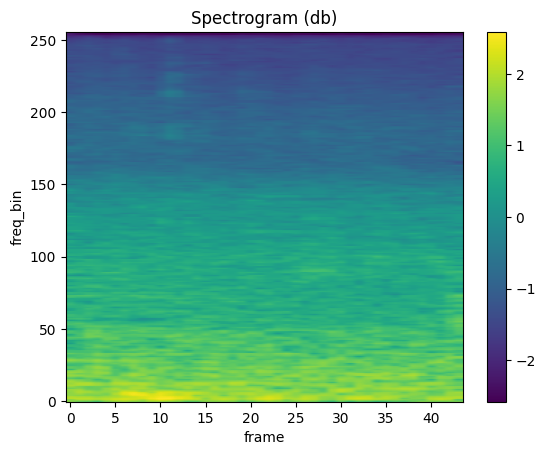

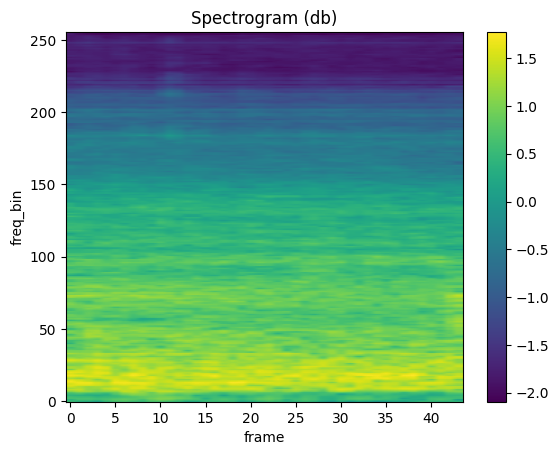

Shape of X [N, C, H, W]: torch.Size([16, 1, 256, 44])
Shape of y: torch.Size([16, 10]) torch.float32


In [85]:
if conf.DIFF_FREQ:
    diff_freq_list = pd.read_pickle(f"/data/jessy/my/reuse/{conf.reusefolder}diff_freq.pkl") 
    if conf.include_val:
        diff_freq_list_val = pd.read_pickle(f"/root/autodl-tmp/my/reuse/{conf.reusefolder}diff_freq_val.pkl") 
        diff_freq_list = pd.concat([diff_freq_list, diff_freq_list_val])
    display(diff_freq_list.head())

    dif_devices_train_list = [
            "b",
            "c",
            "s1",
            "s2",
            "s3",
        ]

    diff_freq_power = torch.from_numpy(np.stack(diff_freq_list["dif_freq"].values).astype(np.float32)).clone()
    
def apply_diff_freq(X, diff_freq_power, devices_no):
    if random.randrange(0, 13, 1) != 0: # 1/13skip
        for idx, (X_temp, device_no) in enumerate(zip(X, devices_no)):
            tmp = (device_no==0)*diff_freq_power[random.randrange(0, len(diff_freq_power), 1),:].unsqueeze(0).unsqueeze(2)
            tmp = torch.from_numpy(np.dot(torch.ones((X.shape[3],1)), tmp[:,:,0])).clone()
            X[idx,0,:,:] = X_temp[0,:,:] + tmp.T

    return X

for X, y,devices_no in train_dataloader:
    X, y = X.to("cpu"), y.to("cpu")
    X_ori = normalize_std(X)
    plot_spectrogram(X_ori[0,0,:,:])
    X = apply_diff_freq(X, diff_freq_power,devices_no)
    X = normalize_std(X)
    plot_spectrogram((X[0,0,:,:]))
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

## Train loop

In [22]:
def train(dataloader, model, loss_fn, optimizer, t):
    size = len(dataloader.dataset)
    train_loss = 0
    n_train = 0
    correct = 0
    model.train()

    for batch, (X, y,devices) in enumerate(dataloader):
        
        if conf.MIXUP:
            X = mixstyle(X, p=0.2, alpha=0.3)
        if conf.DIFF_FREQ:
            X = apply_diff_freq(X, diff_freq_power, train_devices)
            
        X = normalize_std(X)  
        X2 = ComputeDeltas(X)
        X2 = normalize_std(X2)   
        X = torch.cat((X,X2),1)
        
        if conf.SPEC_AUG:
            X = spec_augmenter(X)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        output = model(X)
        pred = output[0]+output[1]
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        scheduler.step(t+1)
        train_loss += loss.item()
        
        _, predicted = torch.max(pred.detach(), 1)
        _, y_predicted = torch.max(y.detach(), 1)
        correct += (predicted == y_predicted).sum().item()
        
        n_train += len(X)
        if batch % 500 == 0:
            loss_current, acc_current, current = train_loss/n_train, correct/n_train, batch * len(X)
            print(f"Train Epoch: {t+1} loss: {loss_current:>7f}  accuracy: {acc_current:>7f} [{current:>5d}/{size:>5d}]")
    
    loss_current, acc_current = train_loss/n_train, correct/n_train   
    return loss_current, acc_current

In [23]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    val_loss = 0
    n_val = 0
    correct = 0
    model.eval()
    with torch.no_grad():        
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            
            output = model(X)
            pred = output[0]+output[1]
            loss = loss_fn(pred, y)

            val_loss += loss.item()
            
            _, predicted = torch.max(pred.detach(), 1)
            _, y_predicted = torch.max(y.detach(), 1)
            correct += (predicted == y_predicted).sum().item()
            
            n_val += len(X)
            if batch % 500 == 0:
                loss_current, acc_current, current = val_loss/n_val, correct/n_val, batch*len(X)
                print(f"Val Epoch: {t+1} loss: {loss_current:>7f}  accuracy: {acc_current:>7f} [{current:>5d}/{size:>5d}]")
                
    loss_current, acc_current = val_loss/n_val, correct/n_val
    return loss_current, acc_current

In [ ]:
liveloss = PlotLosses()
min_loss = 5
max_acc = 0
for t in range(conf.epochs):
    logs = {}
    train_loss, train_acc = train(train_dataloader, teacher_model, loss_fn, optimizer, t)
    val_loss, val_acc = val(val_dataloader, teacher_model, loss_fn)
    logs["log loss"] = train_loss
    logs["val_log loss"] = val_loss
    logs["acc"] = train_acc
    logs["val_acc"] = val_acc
    liveloss.update(logs)
    liveloss.send()
        
    if max_acc < val_acc:
        max_acc = val_acc
        torch.save(copy.deepcopy(teacher_model).state_dict(), "model/model_maxacc.pt")

## 模型集成

In [30]:
class EnsembelerModel(nn.Module):
    def __init__(self, models):
        super(EnsembelerModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        # ModuleList can act as an iterable, or be indexed using ints
        all_out = None
        for i, m in enumerate(self.models):
            out = m(x)
            if all_out is None:
                all_out = out
            else:
                all_out = out + all_out
        all_out = all_out / len(self.models)
        return all_out

In [31]:
def get_teacher_avg_ensemble(teachers_list=[], teachers_path="teacher_models"):
    models_list = [Model(n_output, n_hidden),Model(n_output, n_hidden),Model(n_output, n_hidden)]

    for i, tid in enumerate(teachers_list):
        ckpt = torch.load(f"{teachers_path}/teacher_model{tid}.pt")
        models_list[i].load_state_dict(ckpt)
    model = EnsembelerModel(models_list)
    #print(model)
    return model

In [32]:
ENSEMBLE = Model(n_output, n_hidden)
ENSEMBLE = get_teacher_avg_ensemble(teachers_list=[2,3,4])

BSConvU
BSConvU
BSConvU
BSConvU


In [ ]:
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.RAdam(ENSEMBLE.parameters(), lr=1e-3)
scheduler = CosineLRScheduler(optimizer, t_initial=100, lr_min=1e-6, warmup_t=5, warmup_lr_init=5e-5, warmup_prefix=True)

## Validation Results

In [21]:
batch_size = 1
val_result_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
loss_fn_inference = nn.CrossEntropyLoss(reduction="none")
#model = model.to("cpu")

In [ ]:
ENSEMBLE = ENSEMBLE.to("cpu")

In [ ]:
# loading model
teacher_model.load_state_dict(torch.load("model/model_maxacc.pt"))
teacher_model = teacher_model.to("cpu")

In [22]:
def inference(dataloader, model, loss_fn, device):
    loss_all = []
    predicted_all = []
    correct=[0]*9
    cnt=[0]*9
    cor=[0.]*9
    model.eval()
    with torch.no_grad():        
        for batch, (X, y,devices) in enumerate(dataloader):
            X, y= X.to(device), y.to(device)
            
            output = model(X)
            pred = output
            #pred = output[0]+output[1]
            
            loss = loss_fn(pred, y)

            _, predicted = torch.max(pred.detach(), 1)
            _, y_predicted = torch.max(y.detach(), 1)
            correct[devices] += (predicted == y_predicted).sum().item()
            cnt[devices] += 1
            cor[devices]=correct[devices] /cnt[devices]
            
            loss_all.append(loss)
            predicted_all.append(predicted)
    print(correct,cnt,cor)
    return torch.flatten(torch.stack(loss_all)).numpy(), torch.flatten(torch.stack(predicted_all)).numpy()

## 量化前

In [ ]:
start_time = time.time()
loss_all, predicted_all = inference(val_result_dataloader,ENSEMBLE, loss_fn_inference, "cpu")
print('run time {:.5f} s'.format(time.time()-start_time))

In [ ]:
plot_device_wise_log_losses(loss_all, predicted_all, val_y, val_devices, devices)
plot_confusion_matrix(torch.argmax(val_y.detach(), 1), predicted_all)

## 量化后

## 学生网络

In [34]:
model=Model2()
model.qconfig = torch.quantization.get_default_qat_qconfig("qnnpack")

In [37]:
model.train()
model = torch.quantization.prepare_qat(model).to(device)

In [39]:
T = conf.temperature
weight = conf.soft_targets_weight
kl_div_loss = nn.KLDivLoss(log_target=True, reduction="none")   # KL Divergence loss for soft targets
log_softmax = nn.LogSoftmax(dim=-1)
ENSEMBLE = ENSEMBLE.to('cuda')
ENSEMBLE.eval()
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-3)
scheduler = CosineLRScheduler(optimizer, t_initial=100, lr_min=1e-6, warmup_t=5, warmup_lr_init=5e-5, warmup_prefix=True)
model=model.to(device)
loss_fn = nn.CrossEntropyLoss(reduction="sum")

In [40]:
def student_train(dataloader, model, teacher_model,optimizer, t):
    size = len(dataloader.dataset)
    train_loss = 0
    n_train = 0
    correct = 0
    model.train()

    for batch, (X, y,devices) in enumerate(dataloader):
        
        if conf.MIXUP:
            X = mixstyle(X, p=0.2, alpha=0.3)
        if conf.DIFF_FREQ:
            X = apply_diff_freq(X, diff_freq_power, train_devices)
            
        X = normalize_std(X)  
        X2 = ComputeDeltas(X)
        X2 = normalize_std(X2)   
        X = torch.cat((X,X2),1)
        
        if conf.SPEC_AUG:
            X = spec_augmenter(X)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        y_hat = model(X)
        label_loss = loss_fn(y_hat,y)
        # getting teacher predictions
        with torch.no_grad():
            # inference step using teacher ensemble
            y_hat_teacher = teacher_model(X)

        # Temperature adjusted probabilities of teacher and student
        with torch.cuda.amp.autocast():
            y_soft_teacher = log_softmax(y_hat_teacher / T)
            y_soft_student = log_softmax(y_hat / T) 

        # distillation loss
        soft_targets_loss = kl_div_loss(y_soft_student, y_soft_teacher).mean()

        loss = weight*soft_targets_loss + label_loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        scheduler.step(t+1)
        train_loss += loss.item()
        
        _, predicted = torch.max(y_hat.detach(), 1)
        _, y_predicted = torch.max(y.detach(), 1)
        correct += (predicted == y_predicted).sum().item()
        
        n_train += len(X)
        if batch % 500 == 0:
            loss_current, acc_current, current = train_loss/n_train, correct/n_train, batch * len(X)
            print(f"Train Epoch: {t+1} loss: {loss_current:>7f}  accuracy: {acc_current:>7f} [{current:>5d}/{size:>5d}]")
    
    loss_current, acc_current = train_loss/n_train, correct/n_train   
    return loss_current, acc_current

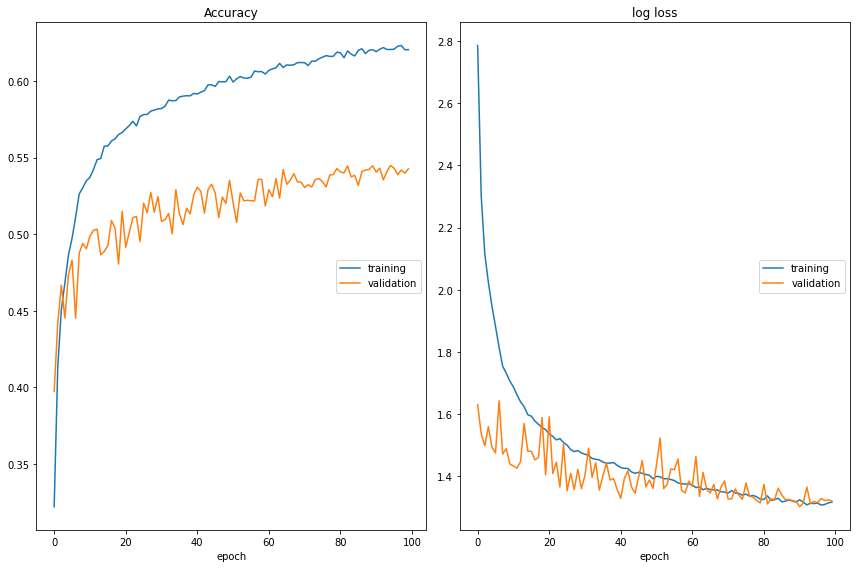

Accuracy
	training         	 (min:    0.322, max:    0.623, cur:    0.621)
	validation       	 (min:    0.397, max:    0.545, cur:    0.543)
log loss
	training         	 (min:    1.308, max:    2.786, cur:    1.317)
	validation       	 (min:    1.303, max:    1.643, cur:    1.321)


In [41]:
liveloss = PlotLosses()
max_acc = 0
for t in range(conf.epochs):
    logs = {}
    train_loss, train_acc = student_train(train_dataloader, model,ENSEMBLE,optimizer, t)
    val_loss, val_acc = val(val_dataloader, model, loss_fn)
    logs["log loss"] = train_loss
    logs["val_log loss"] = val_loss
    logs["acc"] = train_acc
    logs["val_acc"] = val_acc
    liveloss.update(logs)
    liveloss.send()
    if max_acc < val_acc:
        max_acc = val_acc
        torch.save(copy.deepcopy(model).state_dict(), "model/submit1_student.pt")

In [59]:
model.load_state_dict(torch.load("model/student_max.pt"))
model = model.to("cpu")

,Log Loss,a,b,c,s1,s2,s3,s4,s5,s6,Accuracy %
airport,1.520553,1.074507,1.308960,1.380174,1.452359,1.340227,1.507380,1.951248,1.872831,1.790875,42.837841
bus,0.969559,0.400033,1.476084,0.820314,0.922213,0.811923,0.761744,1.152972,1.232390,1.148359,65.488213
metro,1.449373,1.095411,1.880753,1.460733,1.812660,1.319154,1.477606,1.384775,1.531976,1.081286,44.141411
metro_station,1.684127,1.557332,1.937293,2.030681,1.800372,1.529771,1.466452,1.740155,1.731302,1.363784,44.208752
park,0.710191,0.401574,0.293035,0.457589,0.861006,0.944409,0.557330,1.024606,0.760111,1.092060,77.003365
public_square,1.492508,1.361717,2.130970,1.371878,1.268462,1.265623,1.227417,1.408581,1.315523,2.082400,51.919193
shopping_mall,1.134169,1.107641,1.080442,1.234428,1.225014,1.085958,1.087686,1.518803,0.737812,1.129734,60.774410
street_pedestrian,2.046167,1.766643,2.602398,2.262081,1.721349,1.865105,1.783097,2.473091,1.983874,1.957865,36.666664
street_traffic,0.738173,0.580564,0.993760,0.821699,0.502501,0.716597,0.808704,0.475717,0.590081,1.153937,74.579117
tram,1.465319,1.003487,1.623918,1.403567,1.259225,1.303133,1.030913,1.828729,1.907978,1.825053,56.959461


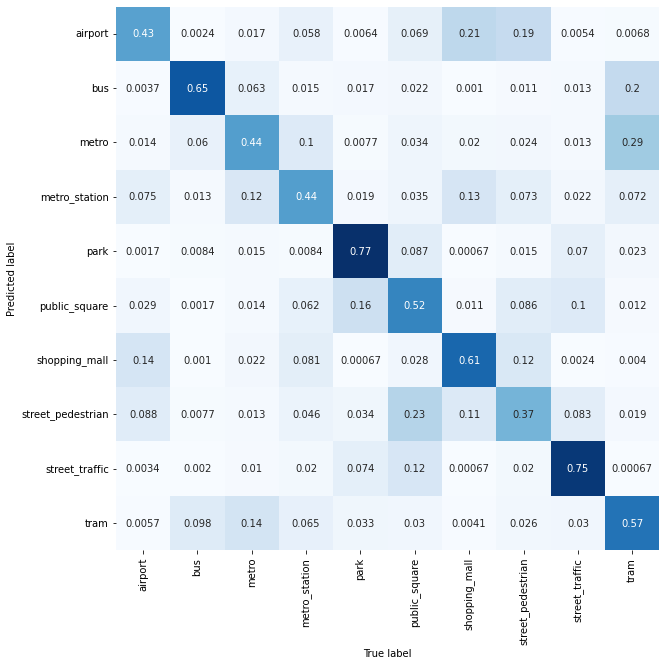

In [54]:
plot_device_wise_log_losses(loss_all, predicted_all, val_y, val_devices, devices)
plot_confusion_matrix(torch.argmax(val_y.detach(), 1), predicted_all)

In [60]:
model_int8 = torch.quantization.convert(model)

In [61]:
start_time = time.time()
loss_all, predicted_all = inference(val_result_dataloader, model_int8, loss_fn_inference, "cpu")
print('run time {:.5f} s'.format(time.time()-start_time))

run time 52.82458 s


,Log Loss,a,b,c,s1,s2,s3,s4,s5,s6,Accuracy %
airport,1.520553,1.074507,1.308960,1.380174,1.452359,1.340227,1.507380,1.951248,1.872831,1.790875,42.837841
bus,0.969559,0.400033,1.476084,0.820314,0.922213,0.811923,0.761744,1.152972,1.232390,1.148359,65.488213
metro,1.449373,1.095411,1.880753,1.460733,1.812660,1.319154,1.477606,1.384775,1.531976,1.081286,44.141411
metro_station,1.684127,1.557332,1.937293,2.030681,1.800372,1.529771,1.466452,1.740155,1.731302,1.363784,44.208752
park,0.710191,0.401574,0.293035,0.457589,0.861006,0.944409,0.557330,1.024606,0.760111,1.092060,77.003365
public_square,1.492508,1.361717,2.130970,1.371878,1.268462,1.265623,1.227417,1.408581,1.315523,2.082400,51.919193
shopping_mall,1.134169,1.107641,1.080442,1.234428,1.225014,1.085958,1.087686,1.518803,0.737812,1.129734,60.774410
street_pedestrian,2.046167,1.766643,2.602398,2.262081,1.721349,1.865105,1.783097,2.473091,1.983874,1.957865,36.666664
street_traffic,0.738173,0.580564,0.993760,0.821699,0.502501,0.716597,0.808704,0.475717,0.590081,1.153937,74.579117
tram,1.465319,1.003487,1.623918,1.403567,1.259225,1.303133,1.030913,1.828729,1.907978,1.825053,56.959461


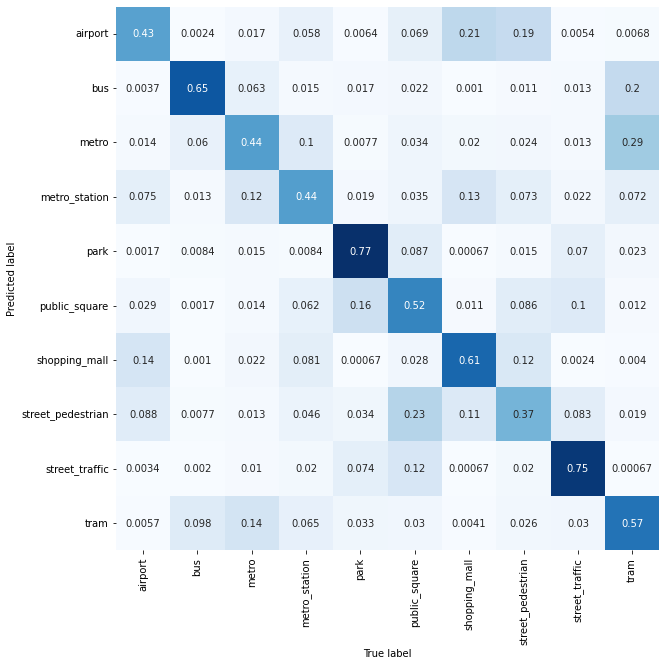

In [62]:
plot_device_wise_log_losses(loss_all, predicted_all, val_y, val_devices, devices)
plot_confusion_matrix(torch.argmax(val_y.detach(), 1), predicted_all)

## 模型2

In [112]:
from BSRN_student import BSConvU
class BSConvLayer(nn.Module):
    def __init__(self, input, output):
        super(BSConvLayer,self).__init__()
        self.BSconv = BSConvU(input,output,3)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(input,eps=1e-03,momentum=0.01)
    def forward(self,x):
        out = self.BSconv(x)
        x = self.relu(self.bn(x+out))
        return x
class Model(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = BSConvU(2,16)
        self.bn = nn.BatchNorm2d(16,eps=1e-03,momentum=0.01)
        self.conv2 = BSConvLayer(16,16)
        self.conv3 = BSConvLayer(16,16)
        self.conv4 = BSConvLayer(16,16)
        self.conv5 = BSConvLayer(16,16)
        self.conv6= BSConvU(16,10,3)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((3,2))
        self.maxpool2 = nn.MaxPool2d((6,4))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(700, n_hidden) 
        self.l2 = nn.Linear(n_hidden, n_output)
    
        
    def forward(self, x):

        out =self.relu(self.bn(self.conv1(x)))
        x = self.conv2(out)
        x = self.conv3(x)
        out = self.maxpool1(x)
        x = self.conv4(out)
        x = self.conv5(x)
        x =self.dropout(self.maxpool2(x))
        x =self.conv6(x)
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.l2(x)
        return x

In [113]:
model2 = Model(10,100)
n_parameters = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print('number of params:', n_parameters)
#model2.qconfig = torch.quantization.get_default_qat_qconfig("qnnpack")
#nessi.get_model_size(model2, "torch", input_size = (1,2,X.shape[2],X.shape[3]))

number of params: 73386


summary(model2, input_size=(1, 2, 256,44), verbose=0)

In [26]:
model2.train()
model2 = torch.quantization.prepare_qat(model2).to(device)

/root/miniconda3/lib/python3.8/site-packages/torch/ao/quantization/quantize.py:264: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


In [27]:
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.RAdam(model2.parameters(), lr=1e-3)
scheduler = CosineLRScheduler(optimizer, t_initial=100, lr_min=1e-6, warmup_t=5, warmup_lr_init=5e-5, warmup_prefix=True)

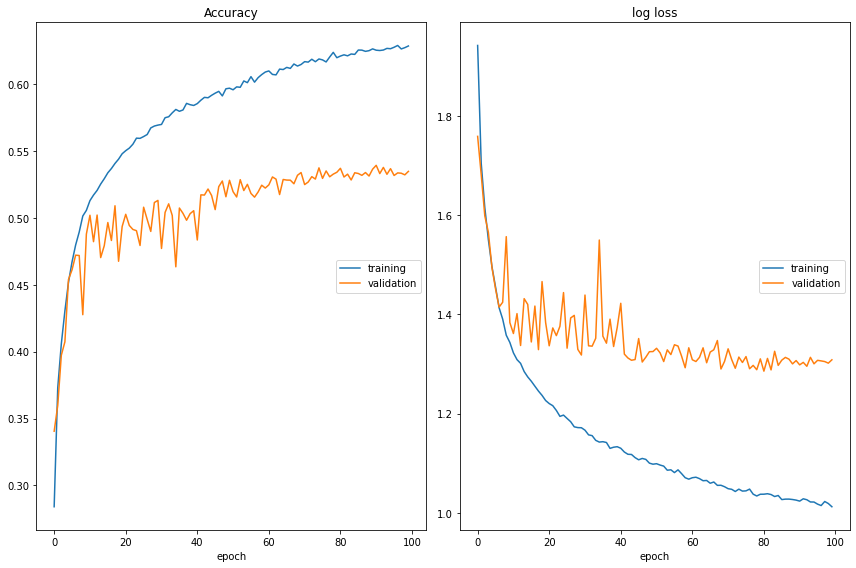

Accuracy
	training         	 (min:    0.284, max:    0.629, cur:    0.628)
	validation       	 (min:    0.340, max:    0.539, cur:    0.535)
log loss
	training         	 (min:    1.012, max:    1.942, cur:    1.012)
	validation       	 (min:    1.285, max:    1.758, cur:    1.308)


In [28]:
liveloss = PlotLosses()
max_acc = 0
for t in range(conf.epochs):
    logs = {}
    train_loss, train_acc = train(train_dataloader, model2, loss_fn, optimizer, t)
    val_loss, val_acc = val(val_dataloader, model2, loss_fn)
    logs["log loss"] = train_loss
    logs["val_log loss"] = val_loss
    logs["acc"] = train_acc
    logs["val_acc"] = val_acc
    liveloss.update(logs)
    liveloss.send()
    
    if max_acc < val_acc:
        max_acc = val_acc
        torch.save(copy.deepcopy(model2).state_dict(), "model/model_max.pt")

torch.save(copy.deepcopy(model2).state_dict(), "model/model.pt")

In [118]:
# loading model
model2.load_state_dict(torch.load("model/submit3.pt"))
model2 =model2.to("cpu")
#print(model2)

In [115]:
start_time = time.time()
loss_all, predicted_all = inference(val_result_dataloader, model2, loss_fn_inference, "cpu")
print('run time {:.5f} s'.format(time.time()-start_time))

[635, 455, 617, 548, 501, 557, 562, 548, 549] [3300, 3290, 3290, 3300, 3300, 3300, 3300, 3300, 3300] [0.19242424242424241, 0.13829787234042554, 0.18753799392097265, 0.16606060606060605, 0.15181818181818182, 0.1687878787878788, 0.1703030303030303, 0.16606060606060605, 0.16636363636363635]
run time 99.95418 s


,Log Loss,a,b,c,s1,s2,s3,s4,s5,s6,Accuracy %
airport,9.656500,8.649000,9.559355,9.923898,9.900328,9.283252,9.822843,9.647136,9.632360,10.487380,0.033784
bus,2.187025,1.323552,2.622175,1.557410,2.228707,2.982047,2.104775,2.417913,2.222663,2.223984,22.424242
metro,4.620079,4.545604,4.873710,4.750545,4.359105,5.304133,4.390188,4.673256,4.379747,4.304423,2.760943
metro_station,6.481320,6.168500,7.397929,6.475016,6.681611,6.245150,6.522409,6.470128,5.980395,6.390742,0.101010
park,0.398206,0.368643,0.076133,0.611380,0.358080,0.271006,0.535407,0.401308,0.600486,0.361411,88.047134
public_square,3.838979,4.215089,4.447201,4.103268,3.985741,3.605145,3.528520,3.437849,3.490693,3.737301,0.572391
shopping_mall,11.903851,11.204583,11.193160,12.518351,11.422340,11.817157,11.691127,12.240120,12.279926,12.767895,0.000000
street_pedestrian,9.553261,8.801361,9.954335,9.900077,9.818968,9.414752,9.415572,9.022510,9.350052,10.301728,0.000000
street_traffic,1.196741,1.241589,1.989034,0.962516,1.081950,1.257653,1.151782,1.007967,0.939160,1.139017,49.494946
tram,3.389648,3.253852,3.900586,3.540646,3.647721,3.003302,2.912778,3.215606,3.625327,3.411592,3.986486


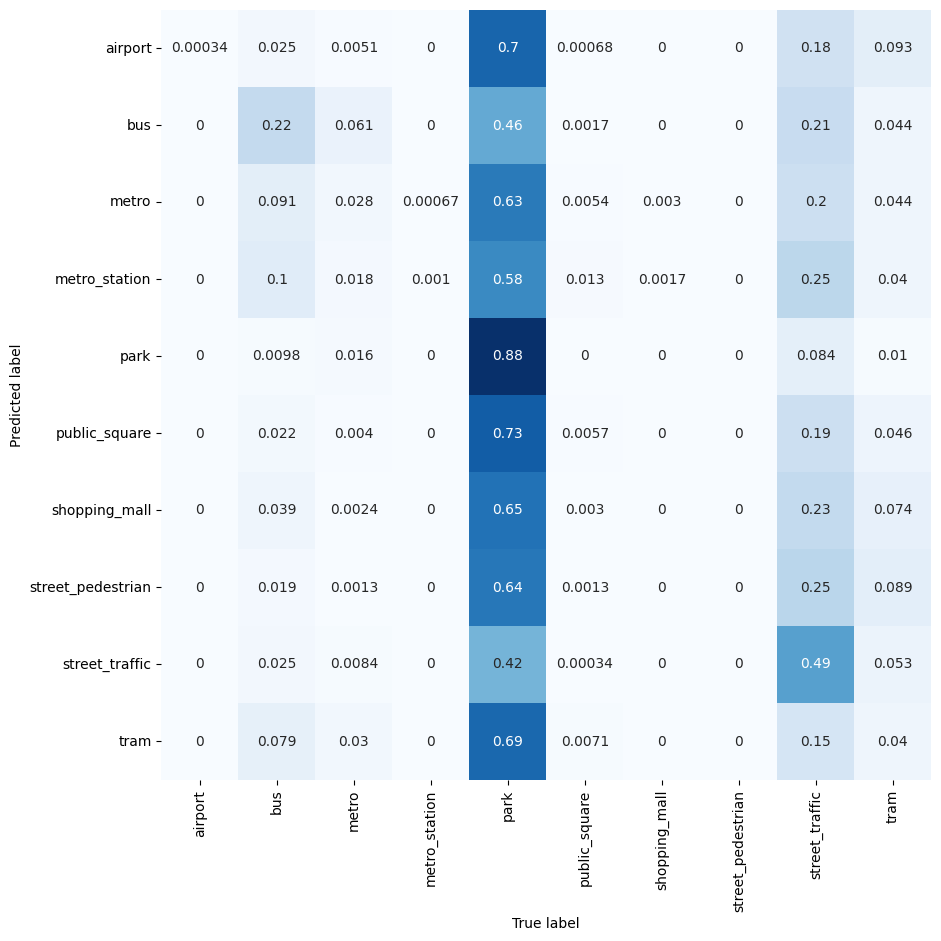

In [116]:
plot_device_wise_log_losses(loss_all, predicted_all, val_y, val_devices, devices)
plot_confusion_matrix(torch.argmax(val_y.detach(), 1), predicted_all)